In [52]:
using Revise
@time using DEBBase
using Plots, StatsPlots
default(titlefontsize = 10, lw = 1.5)

## Effect of nutrient input on growth and reproduction

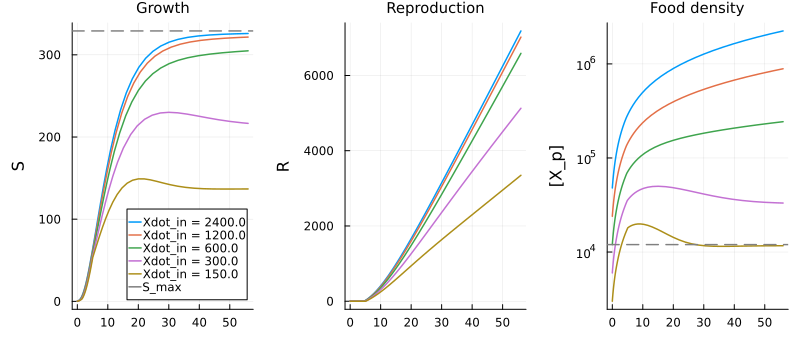

In [93]:
using Revise
using Plots, StatsPlots, Plots.Measures
default(titlefontsize = 10, leg = false)

# prepare the plot
plt = plot(
    layout = (1,3), leg = false, 
    title = ["Growth" "Reproduction" "Food density"], 
    leftmargin = 5mm, bottommargin = 5mm, 
    size = (800,350)
    )

# iterate over nutrient input concentrations
Xdot_in = 4800.
for _ in 1:5
    Xdot_in /= 2
    # generate the predidction
    out = simulator(
        BaseParamCollection(
            glb = GlobalBaseParams(Xdot_in = Xdot_in, t_max = 56.), 
            deb = DEBBaseParams(K_X = 12e3))
        )

    # plot the trajectories
    @df out plot!(plt, :t, :S, ylabel = "S", subplot = 1, leg = true, label = "Xdot_in = $(Xdot_in)") 
    @df out plot!(plt, :t, :R, ylabel = "R", subplot = 2)
    @df out plot!(
        plt, :t, :X_p ./ GlobalBaseParams().V_patch, ylabel = "[X_p]", subplot = 3, 
        yscale = :log10
        )
end
hline!(plt, [DEBBase.calc_S_max(DEBBaseParams())], linestyle = :dash, color = "gray", subplot = 1, label = "S_max")
hline!(plt, [12e3], linestyle = :dash, color = "gray", subplot = 3)
display(plt)


## Benchmarking

Introducing sigmoid switches decreased computation times considerably. With more optimization, it should be possible to get below 5 ms / simulation (200 simulations / s).

In [88]:
@time begin # forcing the code to run for 1 minute, to compare with output of @benchmark
    t0 = now()
    i = 0.
    while now() - t0 <= Second(60)
        out = simulator(
            BaseParamCollection(
                glb = GlobalBaseParams(Xdot_in = 4800., t_max = 21.), 
                deb = DEBBaseParams(K_X = 12e3))
            )
        i += 1
    end
    println("Carried out $i simulations in $(now() - t0).")
end

Carried out 3651.0 simulations in 60 seconds.
 60.011163 seconds (655.23 M allocations: 24.392 GiB, 5.55% gc time, 0.02% compilation time)


In [89]:
using BenchmarkTools
using DEBBase

@benchmark out = simulator(
        BaseParamCollection(
            glb = GlobalBaseParams(Xdot_in = 4800., t_max = 21.), 
            deb = DEBBaseParams(K_X = 12e3))
        )

BenchmarkTools.Trial: 307 samples with 1 evaluation.
 Range (min … max):  14.534 ms … 34.766 ms  ┊ GC (min … max): 0.00% … 32.87%
 Time  (median):     15.187 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   16.327 ms ±  2.485 ms  ┊ GC (mean ± σ):  5.47% ±  9.72%

   ▃▅██▆▄▂                                  ▂▂▂                
  ████████▇▆▄▄▇▁▄▆▇▆▄▇▆▄▁▁▁▄▁▁▁▁▁▁▁▁▄▁▁▄▁▁▁▁███▇█▇▁▇▄▁▄▆▄▁▁▁▄ ▇
  14.5 ms      Histogram: log(frequency) by time      22.8 ms <

 Memory estimate: 6.84 MiB, allocs estimate: 179460.